# Import library


In [60]:
%%time 
import json
import re
import numpy as np
import ast
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple

Wall time: 0 ns


# Read Json file


In [61]:
data = []
with open('qa_Electronics.json') as f:
    for line in f:
        data.append(ast.literal_eval(line))

# Preprocessing Data

In [62]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords
def normalize_text(text):
    # Convert the text to lower, remove tag (<br>, <html>,...), remove punctuation (.,/...), remove multiple space
    filterString = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces]
    # Convert some words have the same meaning to 1 type
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    # Remove stop word
    text = remove_stopwords(text)
   
    return preprocess_string(text, filterString)

# Select sentence to train
 We used the line number to make a tag for sentence to make sure each sentence has a tag and when we have a tag from model we can easy to trace the answer for sentence. <br>
    We also used a trick which we think can help to keep the context of question. After preprocessing, we added the product Id (asin) to the vector. We tried from 1 -> 20 and we used 5 because it showed us the balance result, we can make the model understand which product we are taking about and it can understand the meaning of the sentence base on other words. If we put too less product Id, it can't understand well the product we are talking about and it can return the answer from other products. It we put too much product Id, it will lose the meaning of sentence, it always return the shortest sentence because it just understand the product ID.<br>
    
 It is so mess if we push the code to test our trick so we removed it and accept the result of 10. We will focus on perfomance of model which is more important.
  

In [63]:
# 
alldocs = []
testdocs = []
for line_no, item in enumerate(data):
    words = normalize_text(item['question'])
    length = len(words)
    testdocs.append(length)
    if length >= 3:
        for i in range(5):
            words.append(item['asin'])
        tags = [line_no + 1]
        alldocs.append(TaggedDocument(words, tags))

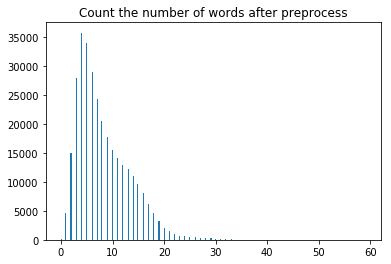

In [65]:
import matplotlib.pyplot as plt

plt.hist(testdocs, bins='auto')
plt.title("Count the number of words after preprocess")
plt.show()

# Shuffer Data

In [8]:
from random import shuffle
doc_list = alldocs[:]
shuffle(doc_list)

# Create Model
   We will use gensim library to implement our model. Base on their research the GPU doesn't perform better than CPU, so their algorithm was implemented with CPU and doesn't support GPU. We will use local computer to train and test performance our model. This computer have 4 cores, 8 threads and 32gb RAM. <br>
   We have 2 algorithms to use with doc2vec (distributed memory and Distributed Bag of Words). Base on the paper of doc2vec (Quoc Le, Tomas Mikolov) we can know that distributed memory will take more time to train and they recommended concate 2 model to have a better result. So we will try to test each model and try to concate them to compare the result.<br>
   In the papers which we read, they recommended vector size from 100 to 300, more than 300, it can't show the better result. So we will test with vector size = 100, 200 and 300.<br>
   Most of vector have a size shorter than 10 when we add 5 more product IDs, they will become less than 15. So we can choose window size is 5. With window size is 5, in most of cases, it can understand the meaning of the context and understand the product ID we put in before.<br>
   Our data is not too big so we will choose the negative sample = 12 base on recommend from word2vec paper ( they recommended the negative sample is 5 - 20 for small training data set). <br>
   We will choose epochs with 3 value 20, 50 and 100 to compare the quality.
   We will try to use the maximum resource so we will take the worker equal the cores in this computer.
   

In [9]:
%%time
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing
cores = multiprocessing.cpu_count()
modelsToTest = []
dm = [0,1]
vectorSize = [100,200, 300]
epochCount = [20, 50, 100]
# we will create total 18 models to test
for item in dm:
    for vector in vectorSize:
        for epoch in epochCount:
            model = Doc2Vec(dm=item, vector_size=vector, window=5, negative=12, hs=0, min_count=10, epochs=epoch, workers=cores)
            model.build_vocab(doc_list)
            modelsToTest.append(model)


Wall time: 1min 56s


In [10]:
len(modelsToTest)

18

# Training Model

In [11]:
for model in modelsToTest:
    %time model.train(doc_list, total_examples=len(doc_list), epochs=model.epochs)

Wall time: 3min 16s
Wall time: 8min
Wall time: 16min 45s
Wall time: 3min 41s
Wall time: 8min 56s
Wall time: 17min 35s
Wall time: 3min 52s
Wall time: 9min 28s
Wall time: 18min 35s
Wall time: 7min 20s
Wall time: 17min 35s
Wall time: 34min 35s
Wall time: 7min 10s
Wall time: 17min 39s
Wall time: 33min 51s
Wall time: 6min 49s
Wall time: 17min 5s
Wall time: 34min 16s


In [12]:
temp = 0
for i in modelsToTest:
    model.save("nlpProject" + str(temp) + ".model")
    temp = temp + 1


# Test DataSet
  This is the dataset which we prepared. Doc2vec is an unsupervised learning. So it is very difficult to test. We choose the way to test it by appling it to real live. We will choose 100 sentences random from our dataset, we rewrite and put them into the model. And we will compare the result with our data. It maybe not the best solution to test but we think it's good for us to know which model is better. AT that time we chose sentence with more than 10 words before processing. In future, if we want to improve it, we can make with more and shorter sentences. 

In [40]:
dataTest = []
with open('data_test.json') as f:
    for line in f:
        dataTest.append(ast.literal_eval(line))

In [15]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
modelsToTest = []
for i in range(18):
    loadedModel = Doc2Vec.load("nlpProject" + str(i) + ".model")
    modelsToTest.append(loadedModel)



In [58]:
listAccuracy = []
accuracy = 0
for item in dataTest:
    tokenQuestion = normalize_text(item['question_modified'])
    for i in range(10):
        tokenQuestion.append(item['asin'])
    inferred_docvec = modelsToTest[1].infer_vector(tokenQuestion)
    result = modelsToTest[1].docvecs.most_similar([inferred_docvec], topn=1)[0][0] == item['line_no']
    if result:
        accuracy = accuracy + 1
    listAccuracy.append(accuracy)
print('Model: %s, Epoch: %s, Accuracy: %s' % (modelsToTest[1], modelsToTest[5].epochs, accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model: Doc2Vec(dm/m,d300,n12,w5,mc10,s0.001,t8), Epoch: 100, Accuracy: 34


# Test Model
 We will loop through each model and check with out data test. We will show the information of our model and how many epoch it used to train. <br>
 We will put product Id to our input 5 times to help it know the context about which product we are talking about.

In [82]:
listAccuracy = []
modelNumber = 0
for model in modelsToTest:
    accuracy = 0
    for item in dataTest:
        tokenQuestion = normalize_text(item['question_modified'])
        for i in range(10):
            tokenQuestion.append(item['asin'])
        inferred_docvec = model.infer_vector(tokenQuestion)
        result = model.docvecs.most_similar([inferred_docvec], topn=1)[0][0] == item['line_no']
        if result:
            accuracy = accuracy + 1
    listAccuracy.append(accuracy)
    print('Model Number: %s, Accuracy: %s' % (modelNumber, accuracy))
    modelNumber = modelNumber+1



C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model Number: 0, Accuracy: 36
Model Number: 1, Accuracy: 35
Model Number: 2, Accuracy: 39
Model Number: 3, Accuracy: 39
Model Number: 4, Accuracy: 39
Model Number: 5, Accuracy: 38
Model Number: 6, Accuracy: 39
Model Number: 7, Accuracy: 39
Model Number: 8, Accuracy: 39
Model Number: 9, Accuracy: 39
Model Number: 10, Accuracy: 39
Model Number: 11, Accuracy: 39
Model Number: 12, Accuracy: 39
Model Number: 13, Accuracy: 39
Model Number: 14, Accuracy: 39
Model Number: 15, Accuracy: 39
Model Number: 16, Accuracy: 39
Model Number: 17, Accuracy: 38
